In [2]:
import os 
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision.transforms import ToTensor 
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader 
from torchvision.datasets import ImageFolder 
import torchvision.transforms as T
%matplotlib inline

In [3]:
import os

# Define the directory
data_dir = '/kaggle/input/plant-disease-identification-data'

# List the contents of the directory
contents = os.listdir(data_dir)

# Print the first 10 items
print(contents[:10])


['Cotton Disease']


In [4]:
print(os.listdir(data_dir))
current=os.getcwd()
pathh='/kaggle/input/plant-disease-identification-data/Cotton Disease/train'
classes=os.listdir(pathh)
print(classes)

['Cotton Disease']
['fresh cotton plant', 'fresh cotton leaf', 'diseased cotton plant', 'diseased cotton leaf']


In [5]:
diseased_cotton_leaf_path=os.path.join(pathh, 'diseased cotton leaf')
print("No. of training examples for diseased cotton leaf :", len(diseased_cotton_leaf_path))
diseased_cotton_leaf_files=os.listdir(diseased_cotton_leaf_path)
print(diseased_cotton_leaf_files[:5])

No. of training examples for diseased cotton leaf : 89
['dis_leaf (39)_iaip.jpg', 'dis_leaf (70)_iaip.jpg', 'dis_leaf (43)_iaip.jpg', 'dis_leaf (25)_iaip.jpg', 'dis_leaf (256)_iaip.jpg']


In [6]:
for i in classes:
    result=os.listdir(pathh+"//"+i)
    print(f"No. of images in {i} is ", len(result))

No. of images in fresh cotton plant is  421
No. of images in fresh cotton leaf is  427
No. of images in diseased cotton plant is  815
No. of images in diseased cotton leaf is  288


In [7]:
image_size=32
batch_size=128
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  

In [8]:
train_ds = ImageFolder(
    pathh,
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)

path2 = os.path.dirname(pathh)
path2 = os.path.join(path2, 'val')

val_ds = ImageFolder(
    path2,
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)


In [9]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl=DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [10]:
img, label=train_ds[0]
img.shape

torch.Size([3, 32, 32])

In [11]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

In [12]:
def show_images(images, nmax):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    grid_img = make_grid(images[:nmax], nrow=8)
    ax.imshow(grid_img.permute(1, 2, 0).cpu().numpy())

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

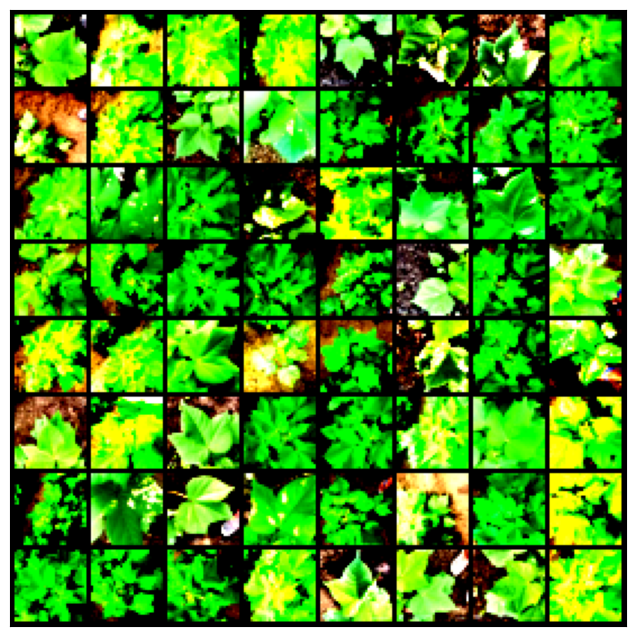

In [13]:
show_batch(train_dl)

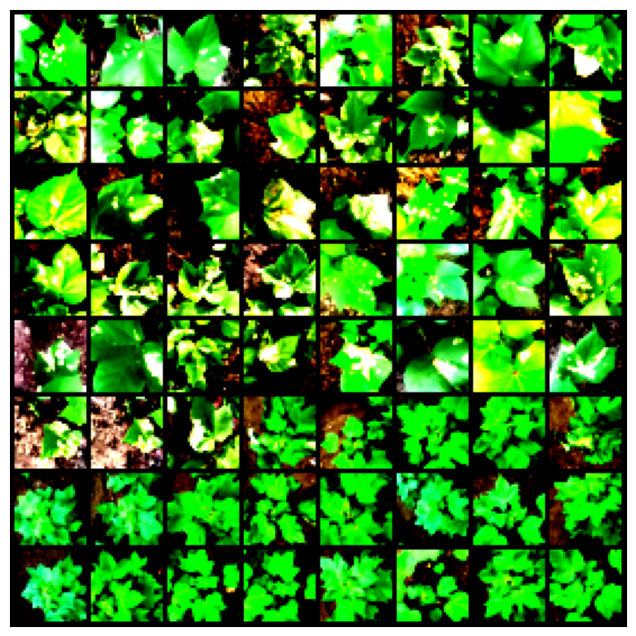

In [14]:
show_batch(val_dl)

In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




In [28]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             3x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [29]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CnnModel().to(device)


for images, labels in train_dl:

    images, labels = images.to(device), labels.to(device)
    
    print('images.shape:', images.shape)
    print('Device of images:', images.device)
    
    out = model(images)
    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    print('Device of output:', out.device)
    
    break


images.shape: torch.Size([128, 3, 32, 32])
Device of images: cuda:0
out.shape: torch.Size([128, 4])
out[0]: tensor([ 0.0137, -0.0315,  0.0071,  0.0355], device='cuda:0',
       grad_fn=<SelectBackward0>)
Device of output: cuda:0


In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
model = to_device(CnnModel(), device)

In [39]:
evaluate(model, val_dl)

{'val_loss': 1.382435917854309, 'val_acc': 0.260869562625885}

In [53]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [54]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6093, val_loss: 0.5017, val_acc: 0.7945
Epoch [1], train_loss: 0.3814, val_loss: 0.3737, val_acc: 0.8498
Epoch [2], train_loss: 0.3366, val_loss: 0.3406, val_acc: 0.8775
Epoch [3], train_loss: 0.2757, val_loss: 0.2566, val_acc: 0.9091
Epoch [4], train_loss: 0.2406, val_loss: 0.2421, val_acc: 0.9209
Epoch [5], train_loss: 0.1880, val_loss: 0.2333, val_acc: 0.9249
Epoch [6], train_loss: 0.1804, val_loss: 0.1922, val_acc: 0.9447
Epoch [7], train_loss: 0.1438, val_loss: 0.1896, val_acc: 0.9486
Epoch [8], train_loss: 0.1234, val_loss: 0.2923, val_acc: 0.9130
Epoch [9], train_loss: 0.1211, val_loss: 0.1764, val_acc: 0.9447
Epoch [10], train_loss: 0.0951, val_loss: 0.2315, val_acc: 0.9328
Epoch [11], train_loss: 0.0844, val_loss: 0.1831, val_acc: 0.9486
Epoch [12], train_loss: 0.0548, val_loss: 0.2119, val_acc: 0.9447
Epoch [13], train_loss: 0.0350, val_loss: 0.1949, val_acc: 0.9447
Epoch [14], train_loss: 0.0356, val_loss: 0.5279, val_acc: 0.9012
Epoch [15], train_lo

In [55]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

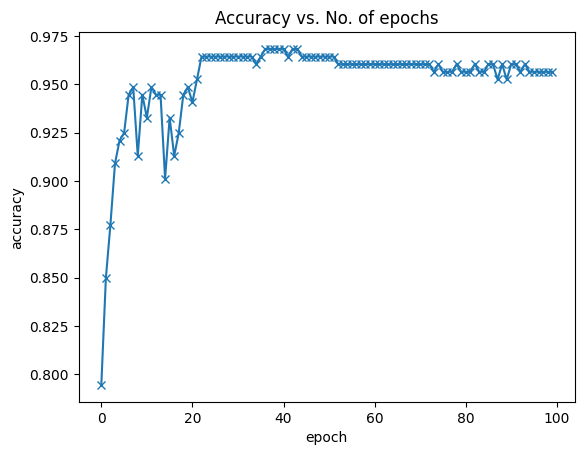

In [56]:
plot_accuracies(history)

In [57]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

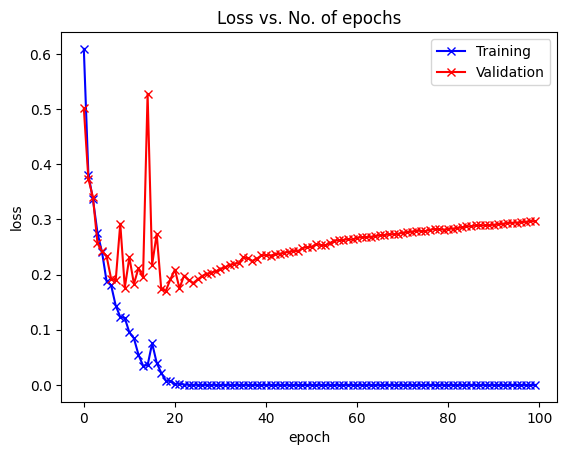

In [58]:
plot_losses(history)

In [59]:
test_dataset = ImageFolder(data_dir + "/Cotton Disease"+"/test", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

In [60]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [61]:
dataset = ImageFolder(data_dir+"/Cotton Disease"+'/train', transform=ToTensor())

In [62]:
torch.save(model.state_dict(), 'modelCottonDemo.pth')

Label: diseased cotton leaf , Predicted: diseased cotton leaf


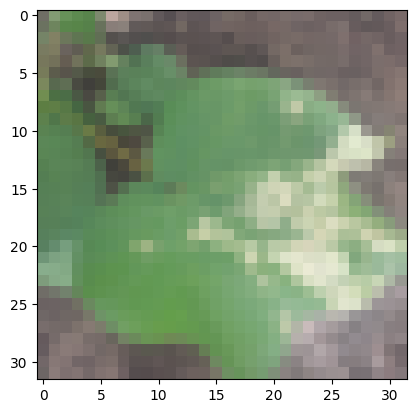

In [63]:
test_dataset1 = ImageFolder(data_dir+'/Cotton Disease'+'/test', transform=ToTensor())
img, label = test_dataset[0]
plt.imshow(denorm(img.permute(1, 2, 0)))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))